# You scanned the QR code, nice! This page presents a quick outline of the performance of a formation energy regressor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
#pandas for data storing
import pandas as pd
#sklearn for ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

Now we import a pickled file local to my machine containing Heulser alloy data.

In [2]:
df_file = open('dataframe_all_heuslers.pkl','rb')
df = pickle.load(df_file)
# Delete Nan values
df = df.dropna()
# Remove duplicate entries, only the most stable alloys remain in the DataFrame
df.drop_duplicates(subset='Compound', inplace=True)

Here we, functions which can build models and deal with the structure of the loaded data in df. 

In [3]:
df.head(1) #this gives us a look at one entry in the dataset

,Compound,spacegroup,Formation_ene,Volume,Magnetic moment,X_electorneg,X_ionization_ene,X_ionization_ene2,X_atomic_no,X_atomic_radius,...,Y_ionization_ene2,Y_atomic_no,Y_atomic_radius,Y_electron_affinity,Z_electorneg,Z_ionization_ene,Z_atomic_no,Z_atomic_radius,Z_electron_affinity,Z_ionization_ene2
1043,B2Ir1Sc1,0,-3.49345,44.4593,0.0,2.04,8.298019,25.15483,5.0,98.0,...,17.0,77.0,136.0,1.5638,1.36,6.56149,21.0,162.0,0.188,12.79977


In [4]:
def make_model_and_plot(data, feature1, feature2, feature3, feature4, target_variable):
    """
    This function takes a DataFrame, feature variables and target variable as arguments.
    Below is an outline of possible values and the property each value corresponds to.
    Features
    1: Electronegativity
    2: First ionization energy
    3: Second ionization energy
    4: Atomic number
    5: Atomic radius
    6: Electron affinity
    The index of each of these features in the DataFrame is shifted by 4.

    Targets
    2: Formation energy
    3: Volume
    4: Magnetic moment
    """
    feature1 += 4
    feature2 += 4
    feature3 += 4
    feature4 += 4
    #Quite painful, but because of how the data is structured this is my workaround for the minute!
    X = np.c_[data.iloc[:,feature1:feature1+1], data.iloc[:,feature2:feature2+1], data.iloc[:,feature3:feature3+1],data.iloc[:,feature4:feature4+1],
          data.iloc[:,feature1+5:feature1+6], data.iloc[:,feature2+5:feature2+6], data.iloc[:,feature3+5:feature3+6],data.iloc[:,feature4+5:feature4+6],
          data.iloc[:,feature1+11:feature1+12], data.iloc[:,feature2+11:feature2+12],data.iloc[:,feature3+11:feature3+12], data.iloc[:,feature4+11:feature4+12]]
    Y = data.values[:,target_variable]
    #We use StandardScaler() to scale the data so mean of each column of X vector is 0,
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    #Split the data into training and test sets so as not to overfit
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
    model = BaggingRegressor(n_estimators=20)
    model.fit(X_train, y_train)
    print("R2 score is: {}".format(r2_score(y_test, model.predict(X_test))))

    plt.figure(figsize=(10,8))
    plt.xlabel("Predicted formation energy/atom (meV)", fontsize=19)
    plt.ylabel("True Formation energy/atom (meV)", fontsize=19)
    plt.plot(model.predict(X_test)*1000, y_test*1000, 'bo', alpha=0.25)
    plt.show()
        
    median_error = np.median(1000*abs(model.predict(X_test) - y_test))
    mean_error = np.mean(1000*abs(model.predict(X_test) - y_test))
    max_error = np.max(1000*abs(model.predict(X_test) - y_test))
    print ("Median error of prediciton versus training data: {0:.2f}meV".format(median_error))
    print ("Mean error of prediction verusus training data: {0:.2f}meV/atom".format(mean_error))
    print ("Max error of prediction versus training data: {0:.2f}meV".format(max_error))

    plt.figure(figsize=(10,8)) 

    plt.hist(1000*abs(model.predict(X_test) - y_test), bins=80)
    plt.axvline(96, color='r')
    plt.annotate('DFT MAE', xy=(89, 700), xytext=(175, 800),
            arrowprops=dict(facecolor='black', shrink=0.1),
            fontsize=19
            )
    plt.xlabel("Error in Formation Energy Prediction (meV)",fontsize=19)
    plt.ylabel("Count",fontsize=19)
    plt.xlim(0,1000)
    plt.show()
    
def return_score(data, feature1, feature2, feature3, feature4, train_size, target):
    """
    This function returns a score used by the learning_curve function to plot learning curves. 
    Variable train_size is passed also, which specifies what number of examples the model
    will be trained on
    """
    feature1 += 4
    feature2 += 4
    feature3 += 4
    feature4 += 4
    X = np.c_[data.iloc[:,feature1:feature1+1], data.iloc[:,feature2:feature2+1], data.iloc[:,feature3:feature3+1],data.iloc[:,feature4:feature4+1],
          data.iloc[:,feature1+5:feature1+6], data.iloc[:,feature2+5:feature2+6], data.iloc[:,feature3+5:feature3+6],data.iloc[:,feature4+5:feature4+6],
          data.iloc[:,feature1+11:feature1+12], data.iloc[:,feature2+11:feature2+12],data.iloc[:,feature3+11:feature3+12], data.iloc[:,feature4+11:feature4+12]]
    Y = data.values[:,target]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
    model = BaggingRegressor(n_estimators=20)
    model.fit(X_train[0:train_size], y_train[0:train_size])
    #print("R2 score is: {}".format(r2_score(y_test, model.predict(X_test))))
    return (r2_score(y_test, model.predict(X_test)))

def learning_curve(data, f1, f2, f3, f4, target_var):
    """
    Learning curves plot the performance of a machine learning model as you increase the number
    of training examples, this is done to ensure that the models are improving as you
    give the algorithm more data.
    """
    trainin_sizes = np.linspace(1000, 55000, 32).astype(int)
    r2_scores = []
    for size in trainin_sizes:
        r2_scores.append(return_score(data, f1, f2, f3, f4, size, target_var))
    plt.figure(figsize=(10,8))
    plt.xlabel("Number of training examples", fontsize=14)
    plt.plot(trainin_sizes, r2_scores)

We create a model with features including electronegativity, first ionization energy, atomic number and atomic radius 

R2 score is: 0.9787892339995626


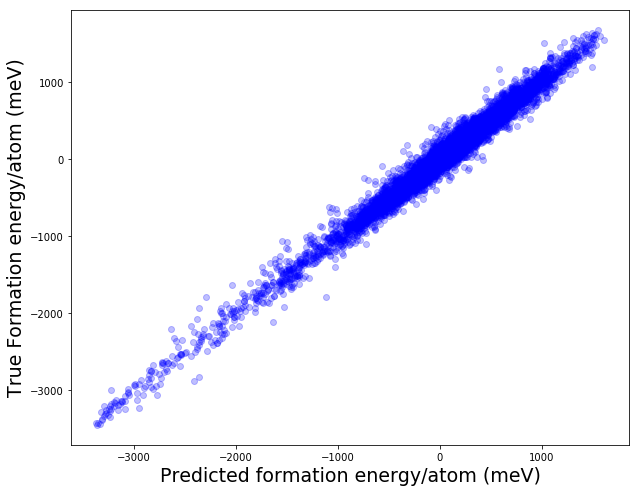

Median error of prediciton versus training data: 48.97meV
Mean error of prediction verusus training data: 65.49meV/atom
Max error of prediction versus training data: 687.10meV


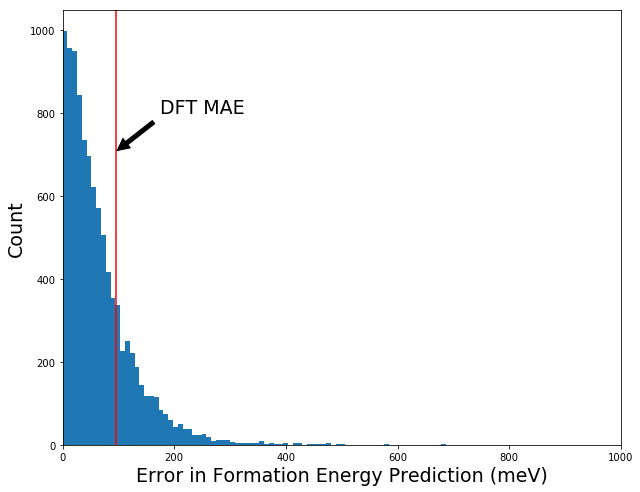

In [5]:
make_model_and_plot(df, 1, 2, 4, 5, 2)

In [ ]:
learning_curve(df, 1, 2, 4, 5, 2)

Cool, the learning curve increases as we would hope and the regressor is working nicely. If you want a quick intro into how the data was created, follow this link https://github.com/craigerboi/QR-code-Project/blob/master/data_extraction.py